In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, EigenCAM
# , AblationCAM
from CAM.ablation_cam import AblationCAM
from CAM.score_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

/home/khmt/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/khmt/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
def input_link(name):
    img = Image.open(name).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    return img_tensor.unsqueeze(0)

In [4]:
def predict_decode(yhat):
    probabilities = torch.softmax(yhat, dim=1)
    top5_prob_indices = torch.topk(probabilities, 5)[1].squeeze(0).tolist()
    
    with open("labels.txt") as f:
        labels = [line.strip() for line in f.readlines()]
    
    top5_labels = [(labels[i], probabilities[0, i].item()) for i in top5_prob_indices]
    for i in top5_labels:
        print(i)
    return (top5_labels[0], int(yhat.argmax()))

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return x

In [6]:
def generate_flat_model(model=model):
    new_model = torch.nn.Sequential(*(list(model.children())[0] + torch.nn.Sequential(model.avgpool) + torch.nn.Sequential(Flatten()) + list(model.children())[2]))
    layers = torch.nn.Sequential(*(list(new_model.children())))
    return layers

In [7]:
image_path = "../ILSVRC2012_val_folders/ILSVRC2012_val_00025002.JPEG"
image_tensor = input_link(image_path)

In [8]:
yhat = model(image_tensor)
result = predict_decode(yhat)

('baseball', 0.6526055932044983)
('ballplayer', 0.34657174348831177)
('croquet ball', 0.0002780611685011536)
('plunger', 0.00011038348020520061)
('shield', 7.413532148348168e-05)


In [9]:
label = result[1]
label

429

In [10]:
# Load the image
img = cv2.imread(image_path)
resized_img = cv2.resize(img, (224, 224))
# Convert BGR to RGB (OpenCV loads images as BGR by default)
img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

In [11]:
# np.max(rgb_img), rgb_img.shape

In [12]:
def show_cam_on_image(
    img: np.ndarray, mask: np.ndarray, use_rgb: bool = False,
    colormap: int = cv2.COLORMAP_JET, image_weight: float = 0.005) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint16(255 * cam)

In [13]:
def cam_func(image, target_layers, cam_model):
    resized_img = cv2.resize(image, (224, 224))
    # Convert BGR to RGB (OpenCV loads images as BGR by default)
    image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    cam = cam_model(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=image_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    # model_outputs = cam.outputs
    # plt.imshow(visualization)
    # plt.show()
    return visualization

def visualization(img):
    plt.imshow(img)
    plt.show()

In [14]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
target_layers = [model.features[-1]]
targets = [ClassifierOutputTarget(label)]

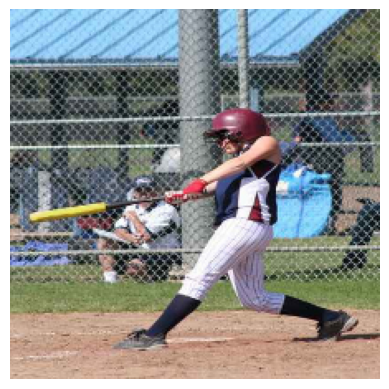

In [16]:
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

[]
[]
__call__
forward
input_tensor : torch.Size([1, 3, 224, 224])


self.outputs : torch.Size([1, 1000])
compute_cam_per_layer
len activations_list: 1
len grads_list: 0
get_target_width_height
get_cam_image
input_tensor: torch.Size([1, 3, 224, 224])
targets: [<pytorch_grad_cam.utils.model_targets.ClassifierOutputTarget object at 0x75e9397c06d0>]
activations: (1, 512, 7, 7)
upsample: UpsamplingBilinear2d(size=torch.Size([224, 224]), mode='bilinear')
activation_tensor: torch.Size([1, 512, 7, 7])
upsampled: torch.Size([1, 512, 224, 224])
maxs: torch.Size([1, 512])
mins: torch.Size([1, 512])
input_tensors: torch.Size([1, 512, 3, 224, 224])
BATCH_SIZE: 16
target: <pytorch_grad_cam.utils.model_targets.ClassifierOutputTarget object at 0x75e9397c06d0>
tensor: torch.Size([512, 3, 224, 224])


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]

scores: torch.Size([512])
scores: torch.Size([1, 512])
weights: (1, 512)
aggregate_multi_layers


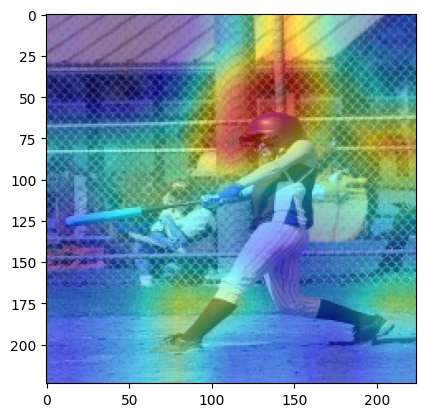

In [17]:
image = cam_func(img, target_layers, ScoreCAM)
visualization(image)

## Metrics

In [18]:
# # Create a 2x4 grid for 8 images
# fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# model_CAM = [GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM]
# # Load and display each image
# for i in range(2):
#     for j in range(3):
#         # Load the image (replace this with your image loading code)
#         print(model_CAM[3*i+j])
#         image = cam_func(img, target_layers, model_CAM[3*i+j])
#         # Display the image
#         axs[i, j].imshow(image)
#         axs[i, j].set_title(f"{model_CAM[3*i+j].__name__}", fontsize=10)
#         axs[i, j].axis('off')  # Hide axes

# plt.show()

In [19]:
# # Create a 2x4 grid for 8 images
# fig, axs = plt.subplots(1, 7, figsize=(10, 5))

# axs[0].imshow(img)
# axs[0].set_title(f"Truth", fontsize=10)
# axs[0].axis('off')  # Hide axes

# model_CAM = [GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM]
# # Load and display each image
# for i in range(len(model_CAM)):
#     # Load the image (replace this with your image loading code)
#     print(model_CAM[i])
#     image = cam_func(img, target_layers, model_CAM[i])
#     # Display the image
#     axs[i+1].imshow(image)
#     axs[i+1].set_title(f"{model_CAM[i].__name__}", fontsize=10)
#     axs[i+1].axis('off')  # Hide axes

# plt.show()